# Importing the required libraries

In [2]:
from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
import PIL
import csv
import pathlib
import torch

import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import matplotlib.pyplot as plt
import pickle

/Users/lsm/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# selecting our gpu accelerator

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Make a custom class for the gtsrb dataset

In [4]:
class GTSRB(Dataset):
    def __init__(self,
                 root: str,
                 split: str,
                 selected_labels: Optional[list[int]] = None,
                 transform: Optional[Callable] = None):
       
        
        
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')
        
        
        with open(''+str(self.csv_file)) as csvfile:
           samples = [(''+str(self.base_folder / row['Path']),int(row['ClassId'])) 
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
            if selected_labels is None or int(row['ClassId']) in selected_labels
                ]


        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple:
        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample,classId
     

# Augmenting our data by applying some transformations (brightness, contrast, vertical-horizontal flip, Rotations, Blur...)

In [5]:
train_transforms = Compose([
    # ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    # RandomEqualize(0.4),
    # AugMix(),
    # RandomHorizontalFlip(0.3),
    # RandomVerticalFlip(0.3),
    # GaussianBlur((3,3)),
    # RandomRotation(30),

    Resize([32,32]),
    ToTensor(),
    
])
validation_transforms =  Compose([
    Resize([32,32]),
    ToTensor(),
    
])

/Users/lsm/Library/Python/3.9/lib/python/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


# splitting our dataset into train and validation 

In [6]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset,[train_size,test_size])

In [7]:
dataset = GTSRB(root='GTSRB_dataset',split="train", selected_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
train_set,validation_set = train_test_split(dataset,train_size=0.8)
print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

training size : 10560, Validation size : 2640


# visualizing the data

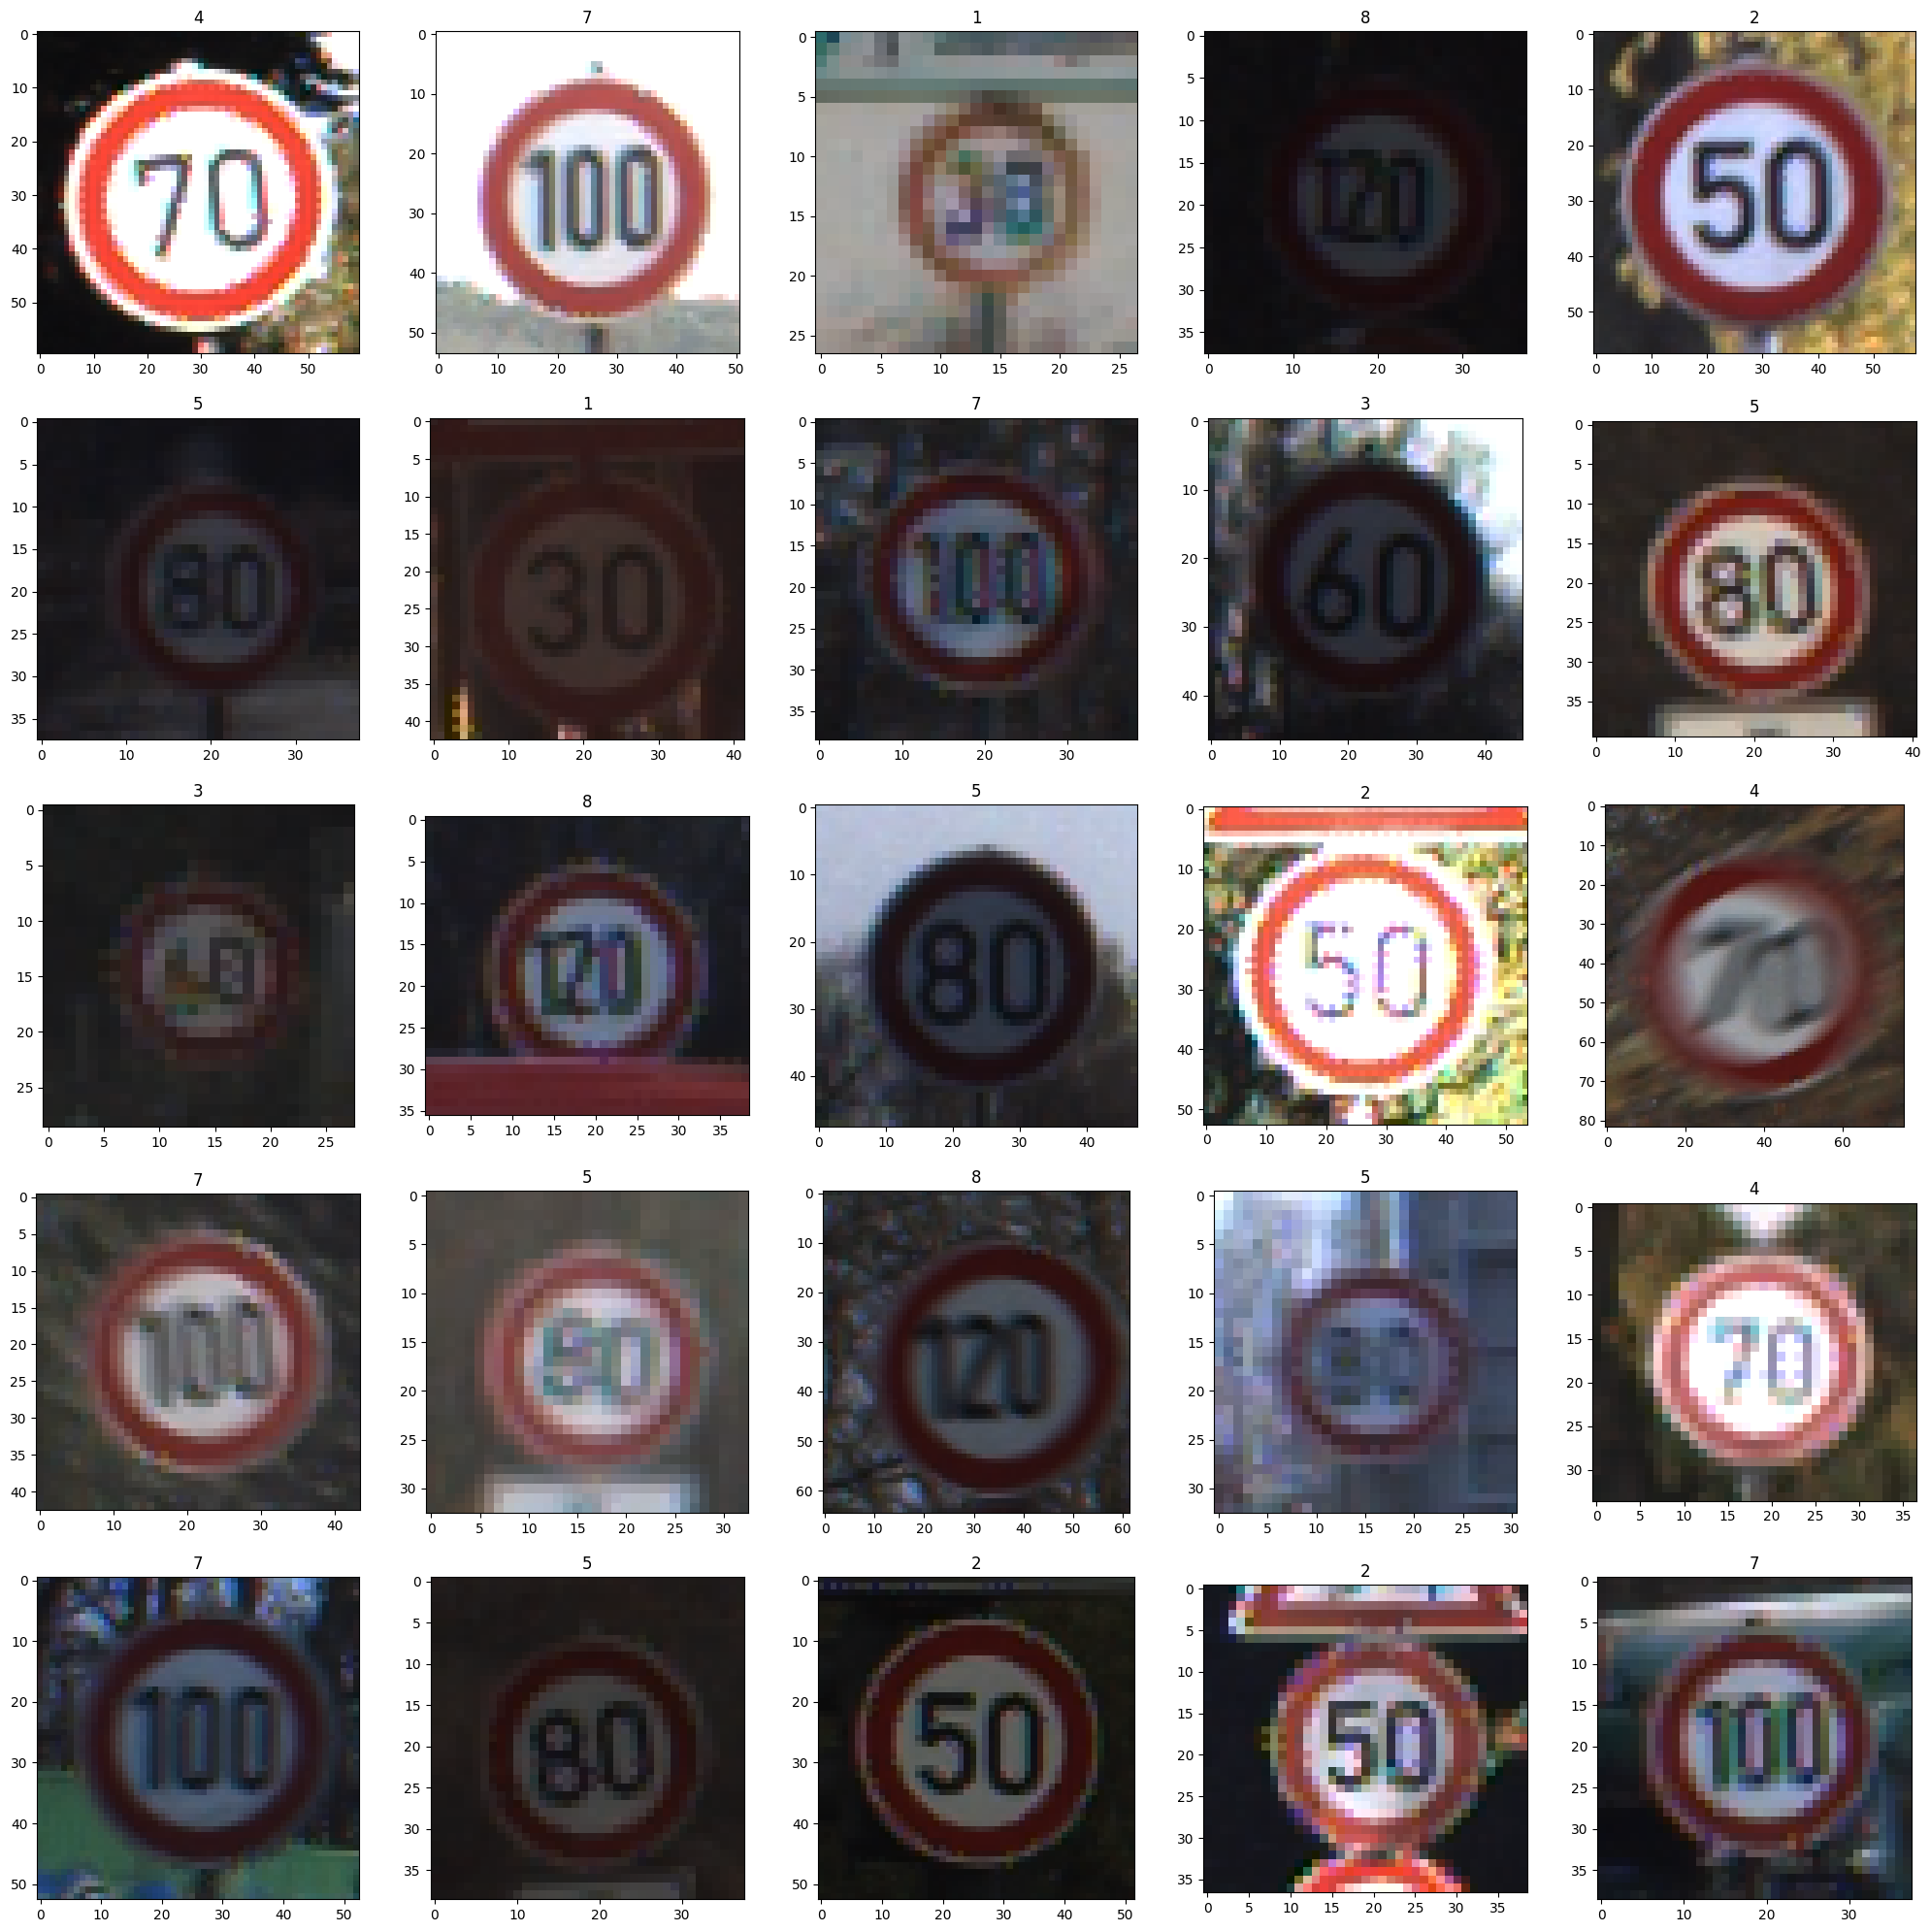

In [8]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)
    

# Applying the transformations

In [9]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

# Loading the data

In [10]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)

# Building a convolutional neural network model

In [11]:
class NN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NN,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

      
      
        self.metrics = {}
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(self.input_dim,50)
        self.l2 = nn.Linear(50,20)
        self.l3 = nn.Linear(20,output_dim)
        
        
    def forward(self,input):
        
        flatten = self.flatten(input)
        dense_l1 = self.l1(flatten)
        act_l1 = self.relu(dense_l1) # 50
        dense_l2 = self.l2(act_l1)
        act_l2 = self.relu(dense_l2) # 20
        output = self.l3(act_l2)
        
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

            


    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

# Training our model

In [12]:
import tqdm
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_DIM = 3*32*32
OUTPUT_DIM = 9
model = NN(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [13]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

training started ...


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch [1/20], Step [165/165], Learning Rate [0.0008], Loss [1.8786], Accuracy [0.2616]: 100%|██████████| 165/165 [00:04<00:00, 37.47it/s]


val_accuracy [0.3090909090909091], val_loss [1.738081455230713]


Epoch [2/20], Step [165/165], Learning Rate [0.00076], Loss [1.6729], Accuracy [0.3682]: 100%|██████████| 165/165 [00:02<00:00, 61.97it/s]


val_accuracy [0.42159090909090907], val_loss [1.5572798252105713]


Epoch [3/20], Step [165/165], Learning Rate [0.00072], Loss [1.2420], Accuracy [0.5133]: 100%|██████████| 165/165 [00:02<00:00, 58.70it/s]


val_accuracy [0.556060606060606], val_loss [1.3534250259399414]


Epoch [4/20], Step [165/165], Learning Rate [0.00068], Loss [1.3267], Accuracy [0.6077]: 100%|██████████| 165/165 [00:02<00:00, 61.94it/s]


val_accuracy [0.6401515151515151], val_loss [1.0106964111328125]


Epoch [5/20], Step [165/165], Learning Rate [0.00064], Loss [1.0036], Accuracy [0.6851]: 100%|██████████| 165/165 [00:02<00:00, 63.77it/s]


val_accuracy [0.7132575757575758], val_loss [0.9412729740142822]


Epoch [6/20], Step [165/165], Learning Rate [0.0006000000000000001], Loss [0.9460], Accuracy [0.7396]: 100%|██████████| 165/165 [00:02<00:00, 64.21it/s]


val_accuracy [0.7401515151515151], val_loss [0.9814387559890747]


Epoch [7/20], Step [165/165], Learning Rate [0.0005600000000000001], Loss [0.7139], Accuracy [0.7558]: 100%|██████████| 165/165 [00:02<00:00, 64.30it/s]


val_accuracy [0.7579545454545454], val_loss [0.8246449828147888]


Epoch [8/20], Step [165/165], Learning Rate [0.0005200000000000001], Loss [0.8507], Accuracy [0.7781]: 100%|██████████| 165/165 [00:02<00:00, 64.39it/s]


val_accuracy [0.7946969696969697], val_loss [0.7549591064453125]


Epoch [9/20], Step [165/165], Learning Rate [0.00048000000000000007], Loss [0.6111], Accuracy [0.7969]: 100%|██████████| 165/165 [00:02<00:00, 63.96it/s]


val_accuracy [0.7897727272727273], val_loss [0.7478747963905334]


Epoch [10/20], Step [165/165], Learning Rate [0.00044000000000000007], Loss [0.6598], Accuracy [0.8069]: 100%|██████████| 165/165 [00:02<00:00, 64.24it/s]


val_accuracy [0.8087121212121212], val_loss [0.7168702483177185]


Epoch [11/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.6153], Accuracy [0.8151]: 100%|██████████| 165/165 [00:02<00:00, 64.15it/s]


val_accuracy [0.8200757575757576], val_loss [0.6927641034126282]


Epoch [12/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.5624], Accuracy [0.8272]: 100%|██████████| 165/165 [00:02<00:00, 64.15it/s]


val_accuracy [0.831060606060606], val_loss [0.76078200340271]


Epoch [13/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.6323], Accuracy [0.8320]: 100%|██████████| 165/165 [00:02<00:00, 64.21it/s]


val_accuracy [0.834469696969697], val_loss [0.732373833656311]


Epoch [14/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.4317], Accuracy [0.8405]: 100%|██████████| 165/165 [00:02<00:00, 62.08it/s]


val_accuracy [0.8234848484848485], val_loss [0.9005513191223145]


Epoch [15/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.5025], Accuracy [0.8454]: 100%|██████████| 165/165 [00:02<00:00, 63.80it/s]


val_accuracy [0.8401515151515152], val_loss [0.8016012907028198]


Epoch [16/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.6224], Accuracy [0.8486]: 100%|██████████| 165/165 [00:02<00:00, 64.42it/s]


val_accuracy [0.8359848484848484], val_loss [0.6036770343780518]


Epoch [17/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.4334], Accuracy [0.8577]: 100%|██████████| 165/165 [00:02<00:00, 64.30it/s]


val_accuracy [0.8583333333333333], val_loss [0.7788611650466919]


Epoch [18/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.5132], Accuracy [0.8587]: 100%|██████████| 165/165 [00:02<00:00, 64.40it/s]


val_accuracy [0.8609848484848485], val_loss [0.7016550302505493]


Epoch [19/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.5977], Accuracy [0.8592]: 100%|██████████| 165/165 [00:02<00:00, 64.13it/s]


val_accuracy [0.8246212121212121], val_loss [0.9505829215049744]


Epoch [20/20], Step [165/165], Learning Rate [0.0004000000000000001], Loss [0.4336], Accuracy [0.8692]: 100%|██████████| 165/165 [00:02<00:00, 65.28it/s]


val_accuracy [0.8651515151515151], val_loss [0.6551931500434875]
training complete !


In [17]:
transforms = Compose([
    Resize([32,32]),
    ToTensor(),
    
])

testdata = GTSRB(root='GTSRB_dataset',split='test', selected_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)




testing size : 4320


/Users/lsm/Library/Python/3.9/lib/python/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [16]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)
        
       

Test Accuracy : 0.7537037037037037 : 100%|██████████| 4320/4320 [00:03<00:00, 1086.73it/s]


In [28]:
# 각 레이어의 출력값을 저장할 리스트
outputs = []

# 콜백 함수 리스트
hook_handles = []

# 각 레이어의 출력값을 저장하는 함수
def save_output(module, input, output):
    outputs.append(output)

# 각 레이어에 출력값 저장 함수 등록
for layer in model.modules():
    hook_handles.append(layer.register_forward_hook(save_output))

# 입력 데이터 생성
input_data = torch.randn(1, 3072)

# test loader에서 데이터를 1개 가져옴
i = 0
for input, label in test_dataloader:
    input_data = input
    if i == 1: #
        break

# 모델 실행
model(input_data)

# 콜백 함수 제거
for hook in hook_handles:
    hook.remove()

# 출력값 확인
    
print('print activation layer (2,4)') 

activation_layer_index = [2, 4]
i = 0
for output in outputs:
    if i in activation_layer_index:
        print(f'Layer {i} : {output}')
    i += 1

print('label :',label.item())

print activation layer (2,4)
Layer 2 : tensor([[1.3612, 8.1004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.3523, 0.0000, 0.0000, 0.4510, 0.0000, 0.0000, 2.8647, 2.1855,
         0.0000, 0.0000, 2.2809, 0.0000, 1.6633, 0.0000, 0.0000, 6.7886, 0.0000,
         0.0000, 0.9223, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.3965,
         1.4331, 3.5961, 0.0000, 2.6400, 0.0000, 5.8429, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 2.9687, 2.0968, 0.0000]], grad_fn=<ReluBackward0>)
Layer 4 : tensor([[2.3519, 0.5481, 0.0000, 0.0000, 1.9296, 0.0000, 0.0000, 0.8131, 0.0000,
         1.6874, 0.9873, 1.4463, 0.0000, 0.0000, 5.6477, 0.0000, 4.1093, 0.0000,
         0.3381, 3.6304]], grad_fn=<ReluBackward0>)
label : 7
